# Conditional Random Field (Custom)

In [3]:
import sys
import os
import cv2
import importlib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Add the parent directory to the Python path
parent_dir = os.path.abspath(os.path.join('../..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [ ]:
from models import get_dfs, METAINFO
import models.postprocessing.crf_custom

importlib.reload(crf_custom)

In [4]:
PATH = '../dataset/' # specify whichever path the csv files are stored in
train_df, val_df, test_df = get_dfs(PATH)

In [3]:
from matplotlib import pyplot as plt
import cv2

for i in range(4):
    image_path = 'crf_2/img' + str(i) + '.png'
    label_path = 'crf_2/label' + str(i) + '.png'
    pred_path  = 'crf_2/pred' + str(i) + '.png'
    # crf_path = 'crf_2/crf' + str(i) + '.png'
    
    image = cv2.imread(image_path, cv2.IMREAD_COLOR).astype('float')
    label = cv2.imread(label_path, cv2.IMREAD_COLOR).astype('float')
    pred = cv2.imread(pred_path, cv2.IMREAD_COLOR).astype('float')
    # crf = cv2.imread(crf_path, cv2.IMREAD_COLOR).astype('float')
    
    plt.figure(figsize=(20, 20))
    plt.subplot(1, 4, 1)
    plt.title('Image')
    plt.axis("off")
    plt.imshow(image)
    
    plt.subplot(1, 4, 2)
    plt.title('Label (Ground Truth)')
    plt.axis("off")
    plt.imshow(label)
    
    plt.subplot(1, 4, 3)
    plt.title('Model Prediction (w/o crf)')
    plt.axis("off")
    plt.imshow(pred)
    
    # plt.subplot(1, 4, 4)
    # plt.title('Model Prediction (with crf)')
    # plt.axis("off")
    # plt.imshow(crf)

AttributeError: 'NoneType' object has no attribute 'astype'

In [10]:
import pandas as pd

# print(image)
image = image.reshape(512*512, 3)

pd.DataFrame(image).value_counts(sort=False)

0    1    2  
0    0    0       297
          1         4
          4         1
     1    0         4
          1         3
                 ... 
255  255  251     112
          252     124
          253     136
          254     207
          255    3325
Name: count, Length: 138702, dtype: int64

In [12]:
def find_palette_index(x):
    r, g, b, = x
    return METAINFO['palette'].index((r.item(), g.item(), b.item()))

In [7]:
def calculate_class_iou(y_true, y_pred, num_classes):
    ious = []
    for cls in range(num_classes):
        true_class = list(map((lambda x: x == cls), y_true))
        pred_class = list(map((lambda x: x == cls), y_pred))
        intersection = np.logical_and(true_class, pred_class).sum()
        union = np.logical_or(true_class, pred_class).sum()
        if union == 0:
            iou = np.nan  # If there is no ground truth or prediction for this class, set IoU to NaN
        else:
            iou = intersection / union
        ious.append(iou)
    return ious

# Function to calculate IoUs for each class
def calculate_class_ious(ground_truth, prediction, num_classes):
    y_preds = []
    y_trues = []
    for y_true, y_pred in zip(ground_truth, prediction):
        y_preds.append(y_pred)
        y_trues.append(y_true)
    y_preds = np.concatenate(y_preds, axis=0)
    y_trues = np.concatenate(y_trues, axis=0)
    y_pred_argmax = list(map(find_palette_index, y_preds))
    y_true_argmax = list(map(find_palette_index, y_trues))
    class_ious = calculate_class_iou(y_true_argmax, y_pred_argmax, num_classes)
    return class_ious

In [14]:
classes = palette = METAINFO['classes']

def print_ious(class_ious):
    merged_classes = []
    merged_ious = []
    for idx, class_name in enumerate(classes):
        if class_name == "pole":
            # Merge pole IoU into other-object
            other_object_idx = classes.index("other-object")
            class_ious[other_object_idx] += class_ious[idx]
        elif class_name == "asphalt":
            # Merge asphalt IoU into other-terrain
            other_terrain_idx = classes.index("other-terrain")
            class_ious[other_terrain_idx] += class_ious[idx]
        elif class_name not in ["vehicle", "pole", "asphalt", "unlabelled"]:
            merged_classes.append(class_name)
            merged_ious.append(class_ious[idx])

    class_iou_pairs = list(zip(merged_classes, merged_ious))
    sorted_class_iou_pairs = sorted(class_iou_pairs, key=lambda x: x[0])
    # for class_name, iou in sorted_class_iou_pairs:
    #     print(f"Class {class_name} IoU: {iou * 100: .2f}")

    MIou = np.nanmean(merged_ious)
    # print(f"Mean IoU: {MIou * 100: .2f}")
    return MIou

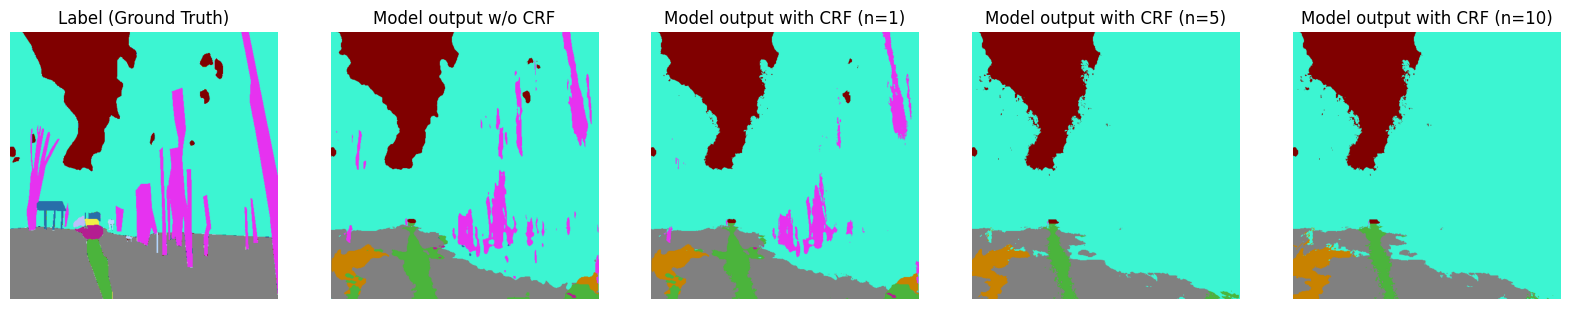

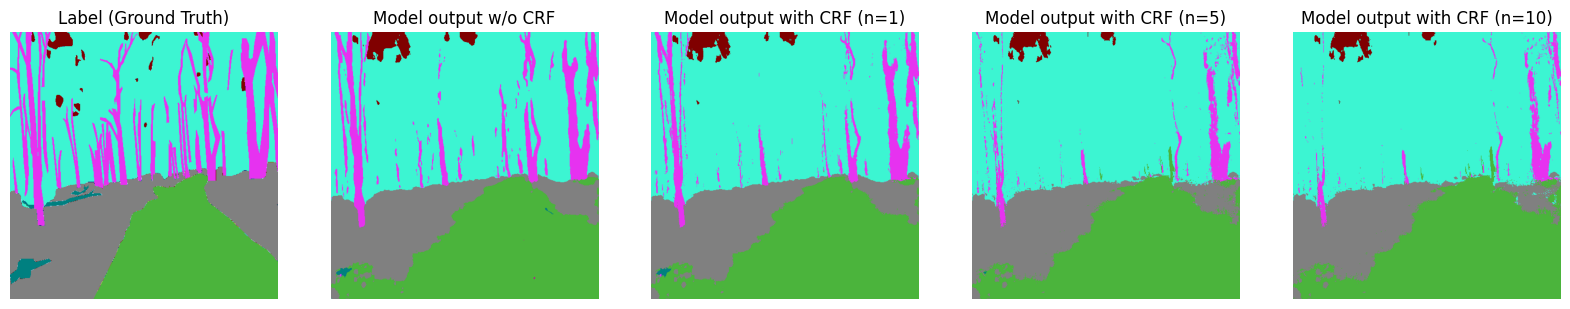

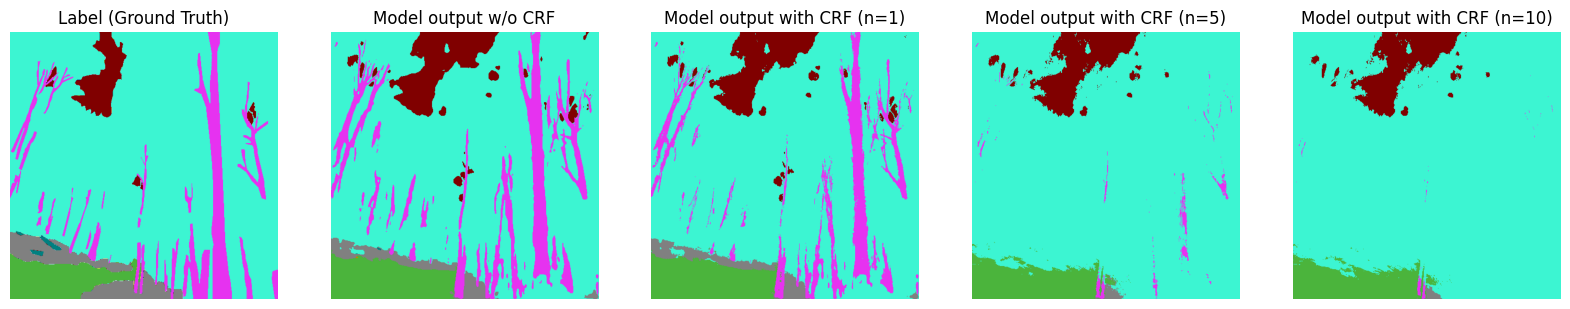

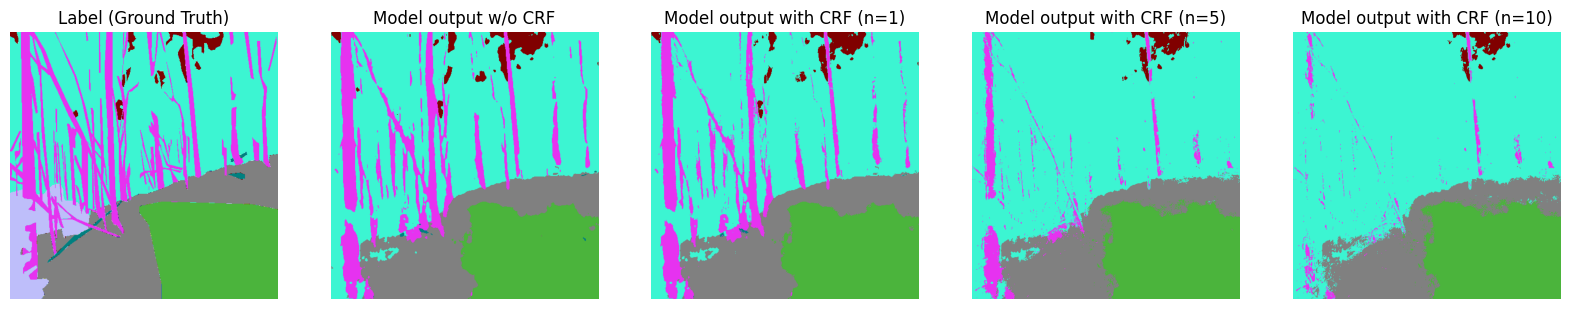

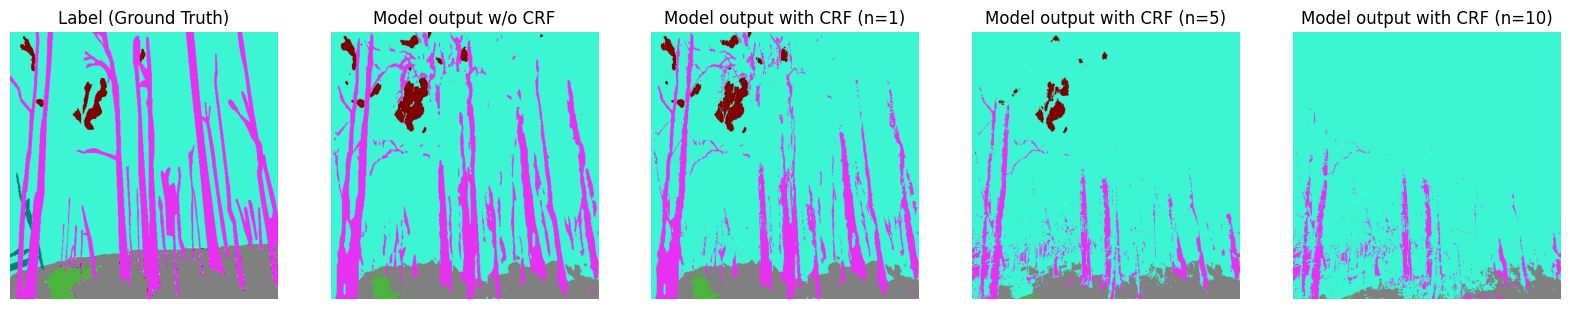

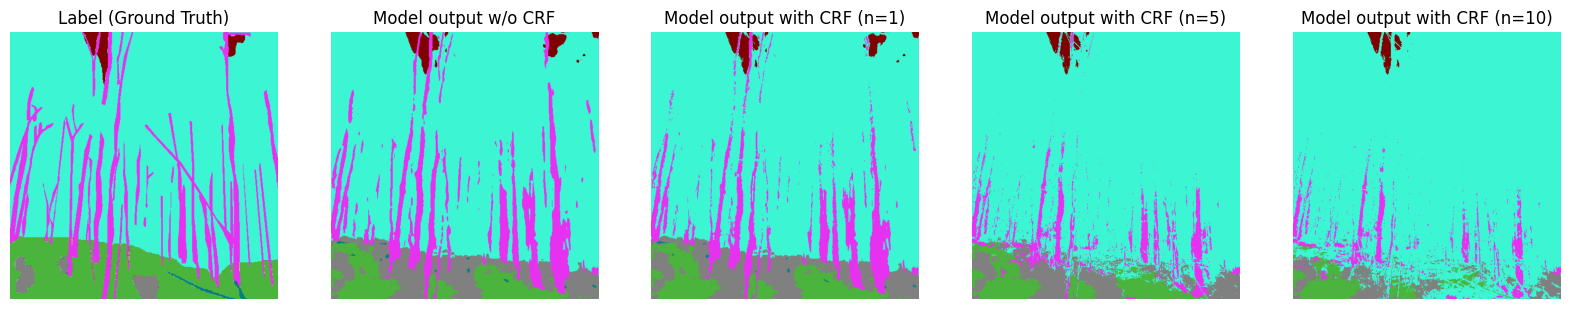

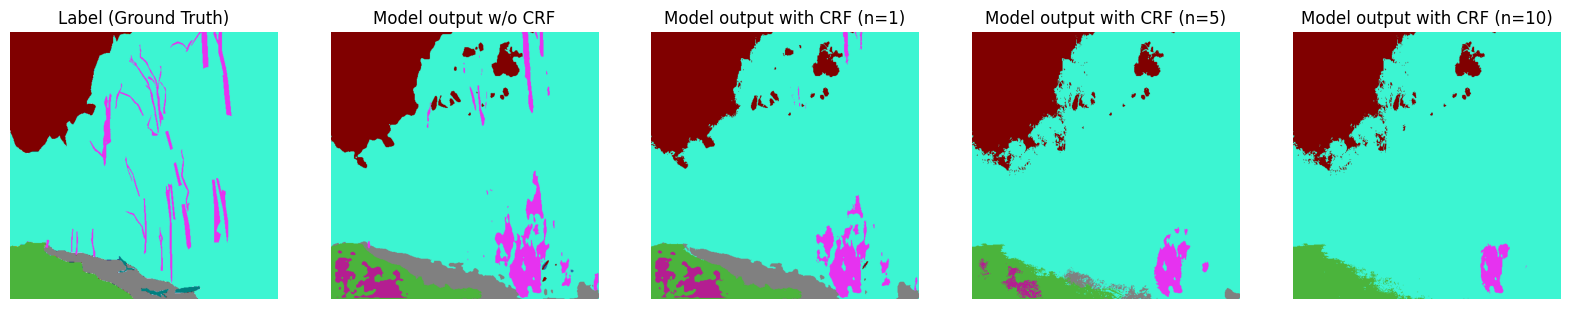

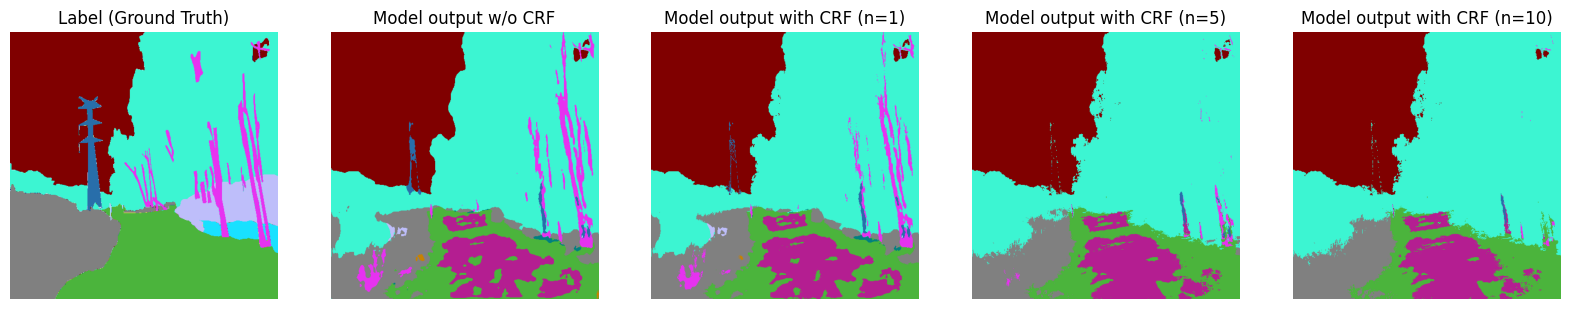

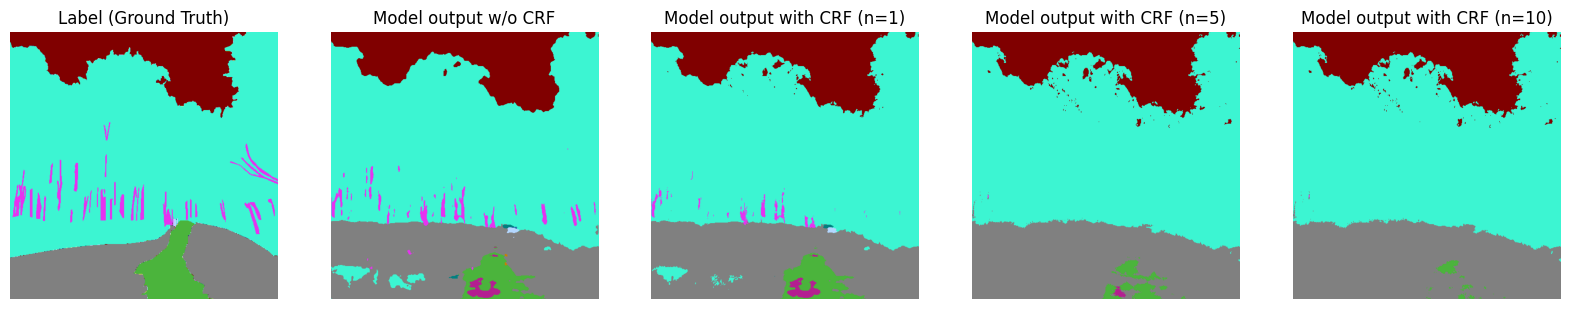

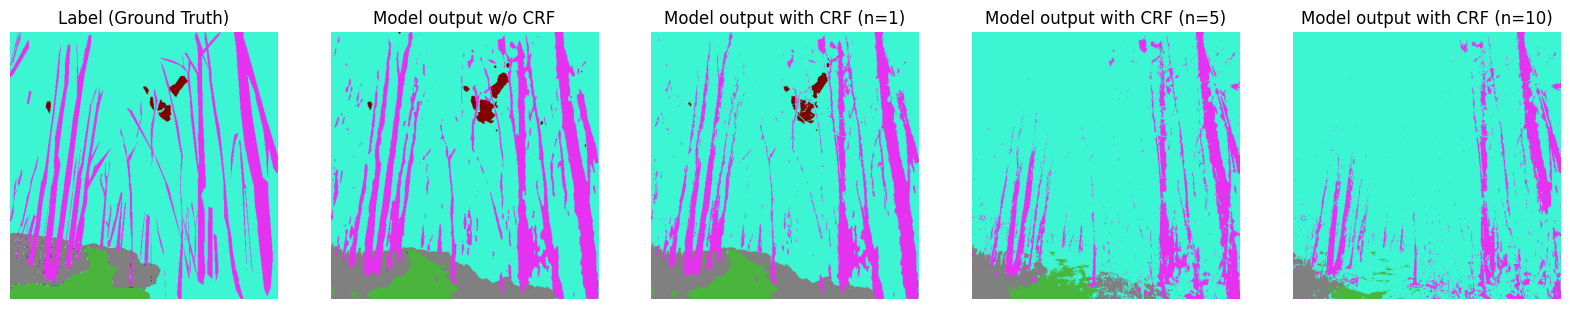

Original:0.201
CRF (n=1):0.197
CRF (n=5):0.163
CRF (n=10):0.145
CRF (n=15):0.138


In [39]:
from matplotlib import pyplot as plt
import cv2
import ..models.crf_custom
import importlib

importlib.reload(crf_custom)

mean_iou = []
mean_iou_crf_1 = []
mean_iou_crf_2 = []
mean_iou_crf_3 = []
mean_iou_crf_4 = []

crf_parameters = [1, 5, 10, 15]

for i in range(10):
    image_path = 'crf_2/img' + str(i) + '.png'
    label_path = 'crf_2/label' + str(i) + '.png'
    pred_path = 'crf_2/pred' + str(i) + '.png'
    
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    label = cv2.imread(label_path, cv2.IMREAD_COLOR)
    pred = cv2.imread(pred_path, cv2.IMREAD_COLOR)
    x, y, c = label.shape
    image = cv2.resize(image, (x, y))
    
    crf1 = crf_custom.crf_main(image, pred, niterations=crf_parameters[0])
    crf2 = crf_custom.crf_main(image, pred, niterations=crf_parameters[1])
    crf3 = crf_custom.crf_main(image, pred, niterations=crf_parameters[2])
    crf4 = crf_custom.crf_main(image, pred, niterations=crf_parameters[3])
        
    plt.figure(figsize=(20, 20))
        
    plt.subplot(1, 5, 1)
    plt.title('Label (Ground Truth)')
    plt.axis("off")
    plt.imshow(cv2.cvtColor(label, cv2.COLOR_RGB2BGR))
    
    plt.subplot(1, 5, 2)
    plt.title('Model output w/o CRF')
    plt.axis("off")
    plt.imshow(cv2.cvtColor(pred, cv2.COLOR_RGB2BGR))
    
    plt.subplot(1, 5, 3)
    plt.title(f'Model output with CRF (n={crf_parameters[0]})')
    plt.axis("off")
    plt.imshow(cv2.cvtColor(crf1, cv2.COLOR_RGB2BGR))
    
    plt.subplot(1, 5, 4)
    plt.title(f'Model output with CRF (n={crf_parameters[1]})')
    plt.axis("off")
    plt.imshow(cv2.cvtColor(crf2, cv2.COLOR_RGB2BGR))
    
    plt.subplot(1, 5, 5)
    plt.title(f'Model output with CRF (n={crf_parameters[2]})')
    plt.axis("off")
    plt.imshow(cv2.cvtColor(crf3, cv2.COLOR_RGB2BGR))
    plt.show()
    
    # Calculate and print IoU for each class
    ious = calculate_class_ious(label, pred, 19)
    iou = print_ious(ious)
    mean_iou.append(iou)
    
    ious_crf_1 = calculate_class_ious(label, crf1, 19)
    iou_crf_1 = print_ious(ious_crf_1)
    mean_iou_crf_1.append(iou_crf_1)
    
    ious_crf_2 = calculate_class_ious(label, crf2, 19)
    iou_crf_2 = print_ious(ious_crf_2)
    mean_iou_crf_2.append(iou_crf_2)
    
    ious_crf_3 = calculate_class_ious(label, crf3, 19)
    iou_crf_3 = print_ious(ious_crf_3)
    mean_iou_crf_3.append(iou_crf_3)
    
    ious_crf_4 = calculate_class_ious(label, crf4, 19)
    iou_crf_4 = print_ious(ious_crf_4)
    mean_iou_crf_4.append(iou_crf_4)

print(f"Original:{round(np.nanmean(mean_iou), 3)}")
print(f"CRF (n={crf_parameters[0]}):{round(np.nanmean(mean_iou_crf_1), 3)}")
print(f"CRF (n={crf_parameters[1]}):{round(np.nanmean(mean_iou_crf_2), 3)}")
print(f"CRF (n={crf_parameters[2]}):{round(np.nanmean(mean_iou_crf_3), 3)}")
print(f"CRF (n={crf_parameters[3]}):{round(np.nanmean(mean_iou_crf_4), 3)}")

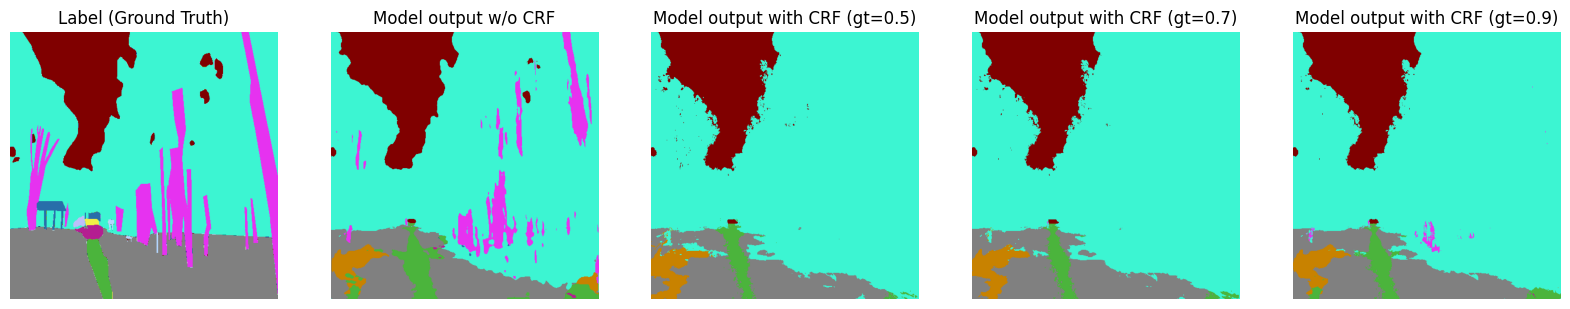

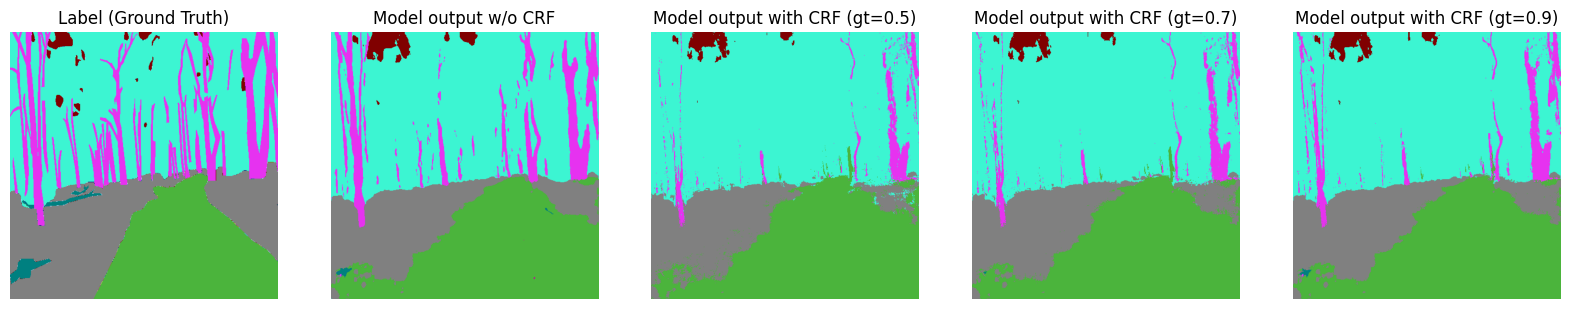

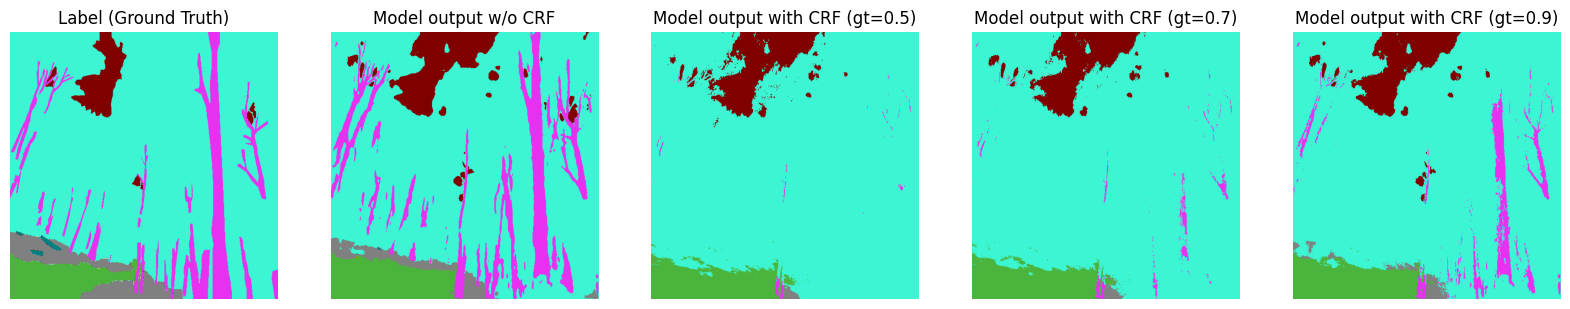

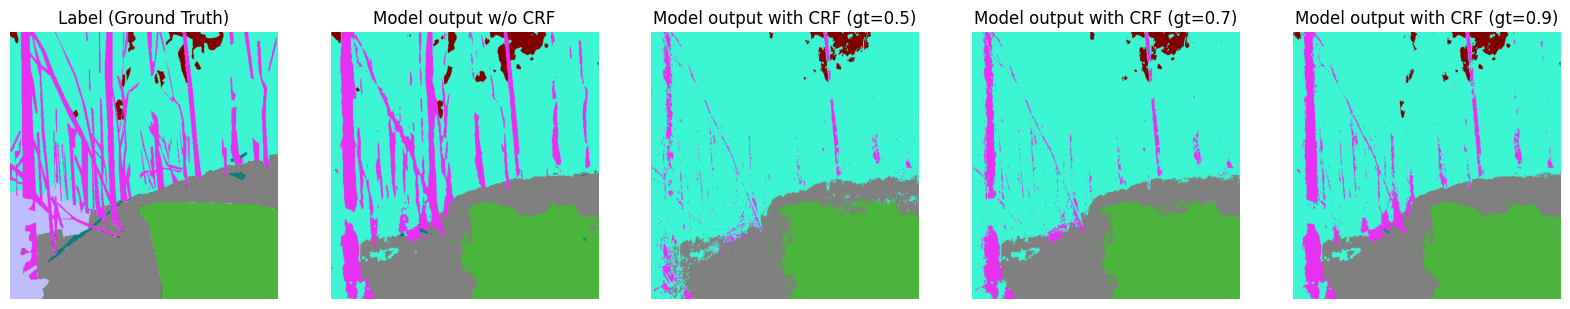

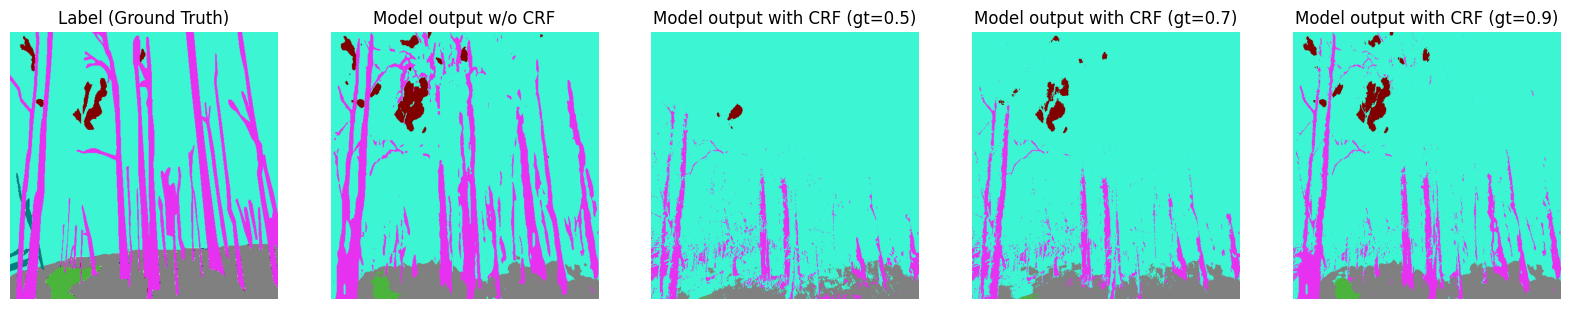

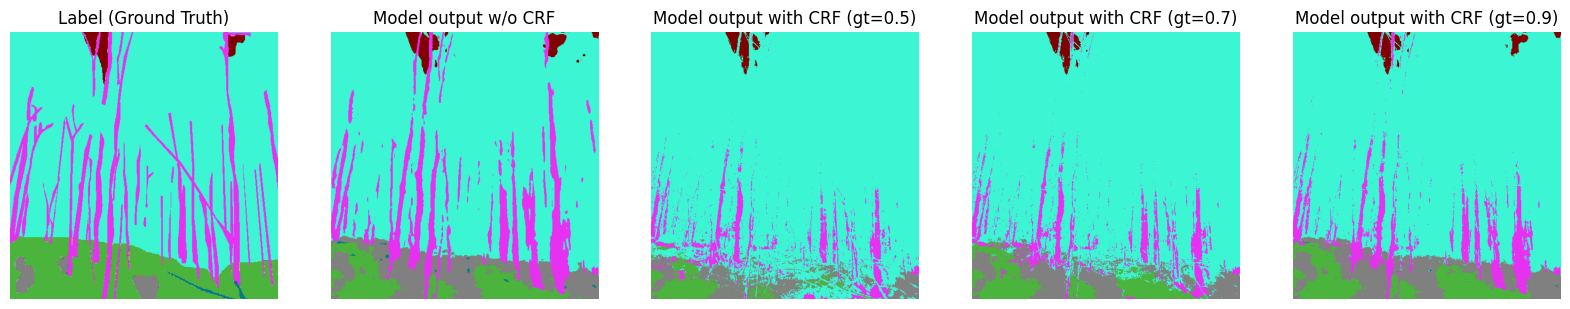

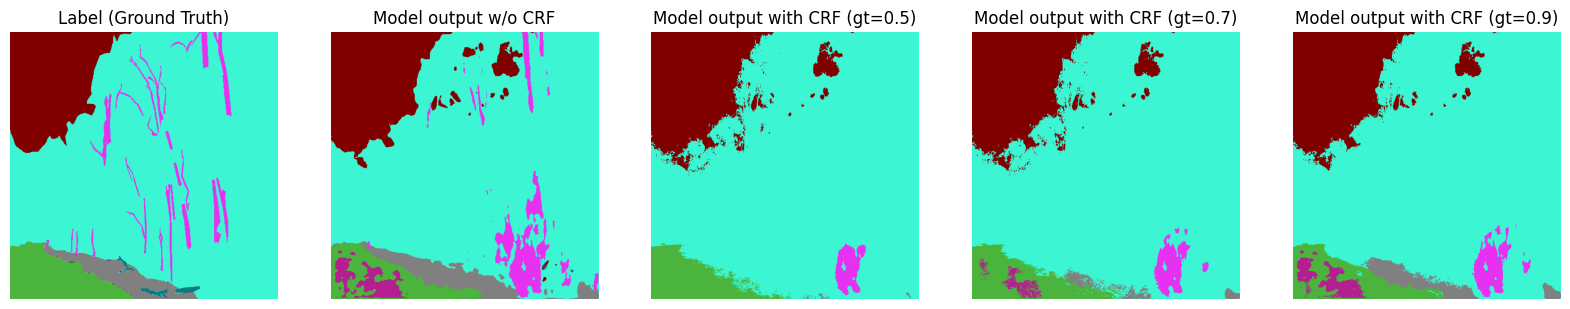

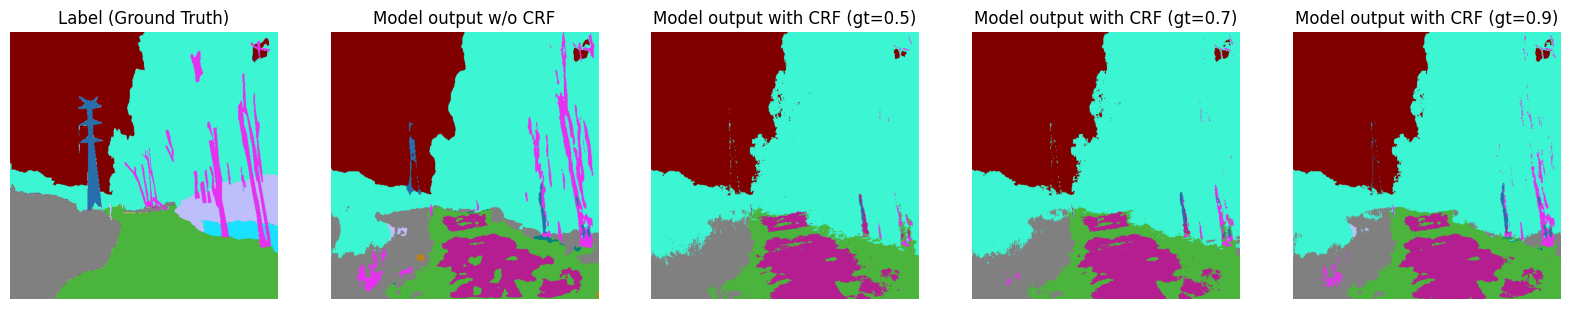

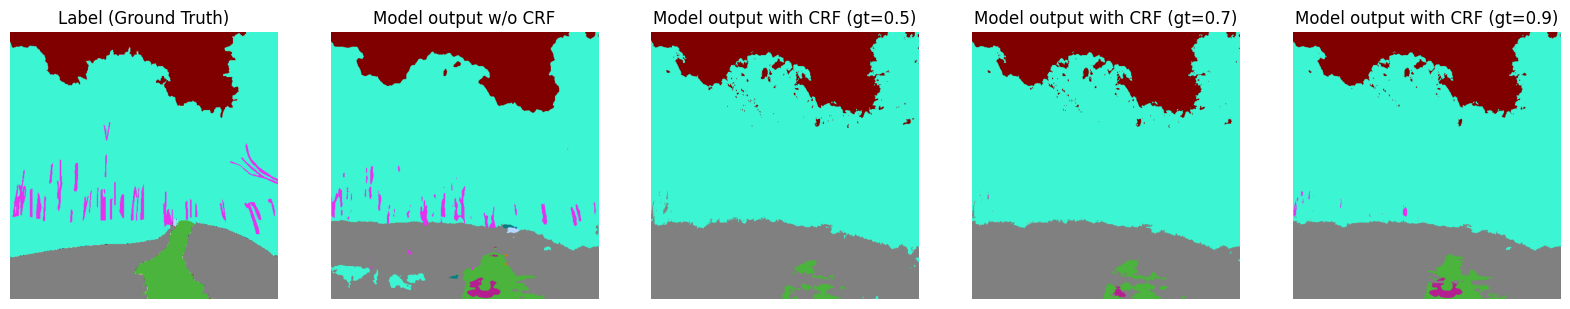

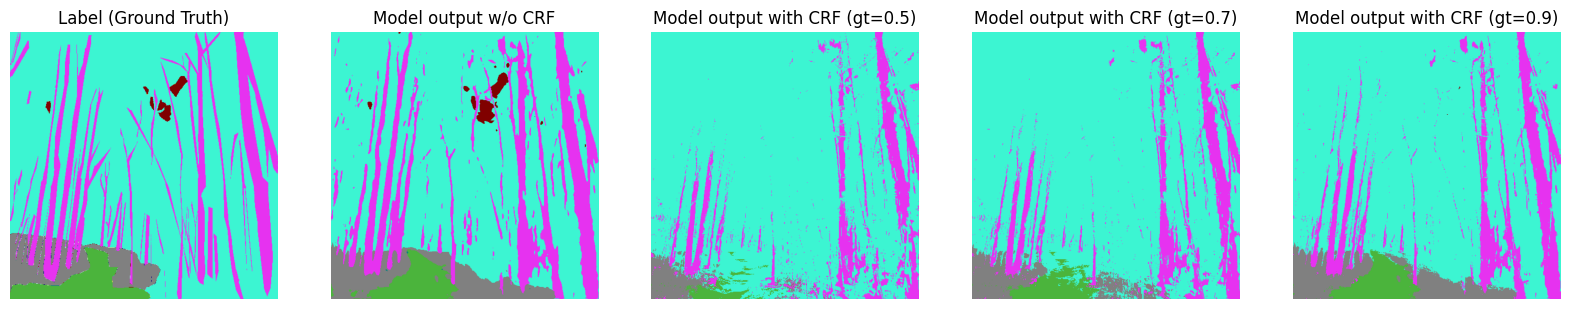

Original:0.201
CRF (gt=0.5):0.15
CRF (gt=0.7):0.163
CRF (gt=0.9):0.179


In [16]:
from matplotlib import pyplot as plt
import cv2
import ..models.crf_custom
import importlib

importlib.reload(crf_custom)

mean_iou = []
mean_iou_crf_1 = []
mean_iou_crf_2 = []
mean_iou_crf_3 = []

crf_parameters = [0.5, 0.7, 0.9]

for i in range(10):
    image_path = 'crf_2/img' + str(i) + '.png'
    label_path = 'crf_2/label' + str(i) + '.png'
    pred_path = 'crf_2/pred' + str(i) + '.png'
    
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    label = cv2.imread(label_path, cv2.IMREAD_COLOR)
    pred = cv2.imread(pred_path, cv2.IMREAD_COLOR)
    x, y, c = label.shape
    image = cv2.resize(image, (x, y))
    
    crf1 = crf_custom.crf_main(image, pred, gt_prob=crf_parameters[0])
    crf2 = crf_custom.crf_main(image, pred, gt_prob=crf_parameters[1])
    crf3 = crf_custom.crf_main(image, pred, gt_prob=crf_parameters[2])
        
    plt.figure(figsize=(20, 20))
        
    plt.subplot(1, 5, 1)
    plt.title('Label (Ground Truth)')
    plt.axis("off")
    plt.imshow(cv2.cvtColor(label, cv2.COLOR_RGB2BGR))
    
    plt.subplot(1, 5, 2)
    plt.title('Model output w/o CRF')
    plt.axis("off")
    plt.imshow(cv2.cvtColor(pred, cv2.COLOR_RGB2BGR))
    
    plt.subplot(1, 5, 3)
    plt.title(f'Model output with CRF (gt={crf_parameters[0]})')
    plt.axis("off")
    plt.imshow(cv2.cvtColor(crf1, cv2.COLOR_RGB2BGR))
    
    plt.subplot(1, 5, 4)
    plt.title(f'Model output with CRF (gt={crf_parameters[1]})')
    plt.axis("off")
    plt.imshow(cv2.cvtColor(crf2, cv2.COLOR_RGB2BGR))
    
    plt.subplot(1, 5, 5)
    plt.title(f'Model output with CRF (gt={crf_parameters[2]})')
    plt.axis("off")
    plt.imshow(cv2.cvtColor(crf3, cv2.COLOR_RGB2BGR))
    plt.show()
    
    # Calculate and print IoU for each class
    ious = calculate_class_ious(label, pred, 19)
    iou = print_ious(ious)
    mean_iou.append(iou)
    
    ious_crf_1 = calculate_class_ious(label, crf1, 19)
    iou_crf_1 = print_ious(ious_crf_1)
    mean_iou_crf_1.append(iou_crf_1)
    
    ious_crf_2 = calculate_class_ious(label, crf2, 19)
    iou_crf_2 = print_ious(ious_crf_2)
    mean_iou_crf_2.append(iou_crf_2)
    
    ious_crf_3 = calculate_class_ious(label, crf3, 19)
    iou_crf_3 = print_ious(ious_crf_3)
    mean_iou_crf_3.append(iou_crf_3)

print(f"Original:{round(np.nanmean(mean_iou), 3)}")
print(f"CRF (gt={crf_parameters[0]}):{round(np.nanmean(mean_iou_crf_1), 3)}")
print(f"CRF (gt={crf_parameters[1]}):{round(np.nanmean(mean_iou_crf_2), 3)}")
print(f"CRF (gt={crf_parameters[2]}):{round(np.nanmean(mean_iou_crf_3), 3)}")

In [19]:
from matplotlib import pyplot as plt
import cv2
import ..models.superpixel
import importlib
importlib.reload(superpixel)


gt_parameters = list(map(lambda x: x/10, [i for i in range(1, 10, 2)]))
gt_mean_ious = []

for parameters in gt_parameters:
    print(f"Parameters = {parameters}")    
    superpixels = []
    ious = []
    total_images = 10
    for i in range(total_images):
        print(f'    Image {i+1}/{total_images}')
        image_path = 'crf_2/img' + str(i) + '.png'
        label_path = 'crf_2/label' + str(i) + '.png'
        pred_path = 'crf_2/pred' + str(i) + '.png'
        
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        label = cv2.imread(label_path, cv2.IMREAD_COLOR)
        pred = cv2.imread(pred_path, cv2.IMREAD_COLOR)
        x, y, c = label.shape
        image = cv2.resize(image, (x, y))
        
        # Computer the superpixel
        output = crf_custom.crf_main(image, pred, gt_prob=parameters)

        # Calculate and print IoU for each class
        iou = print_ious(calculate_class_ious(label, output, 19))
        ious.append(iou)
        
    mean_iou = np.nanmean(ious)
    print(f"crf (n={parameters}):{round(mean_iou, 3)}")
    gt_mean_ious.append(mean_iou)


Parameters = 0.1
    Image 1/10
    Image 2/10
    Image 3/10
    Image 4/10
    Image 5/10
    Image 6/10
    Image 7/10
    Image 8/10
    Image 9/10
    Image 10/10
crf (n=0.1):0.016
Parameters = 0.3
    Image 1/10
    Image 2/10
    Image 3/10
    Image 4/10
    Image 5/10
    Image 6/10
    Image 7/10
    Image 8/10
    Image 9/10
    Image 10/10
crf (n=0.3):0.139
Parameters = 0.5
    Image 1/10
    Image 2/10
    Image 3/10
    Image 4/10
    Image 5/10
    Image 6/10
    Image 7/10
    Image 8/10
    Image 9/10
    Image 10/10
crf (n=0.5):0.15
Parameters = 0.7
    Image 1/10
    Image 2/10
    Image 3/10
    Image 4/10
    Image 5/10
    Image 6/10
    Image 7/10
    Image 8/10
    Image 9/10
    Image 10/10
crf (n=0.7):0.163
Parameters = 0.9
    Image 1/10
    Image 2/10
    Image 3/10
    Image 4/10
    Image 5/10
    Image 6/10
    Image 7/10
    Image 8/10
    Image 9/10
    Image 10/10
crf (n=0.9):0.179


In [26]:
from matplotlib import pyplot as plt
import cv2
import superpixel
import importlib
importlib.reload(superpixel)


iterations_parameters = [i for i in range(1, 10)]
iterations_mean_ious = []

for parameters in iterations_parameters:
    print(f"Parameters = {parameters}")    
    superpixels = []
    ious = []
    total_images = 10
    for i in range(total_images):
        print(f'    Image {i+1}/{total_images}')
        image_path = 'crf_2/img' + str(i) + '.png'
        label_path = 'crf_2/label' + str(i) + '.png'
        pred_path = 'crf_2/pred' + str(i) + '.png'
        
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        label = cv2.imread(label_path, cv2.IMREAD_COLOR)
        pred = cv2.imread(pred_path, cv2.IMREAD_COLOR)
        x, y, c = label.shape
        image = cv2.resize(image, (x, y))
        
        # Computer the superpixel
        output = crf_custom.crf_main(image, pred, niterations=parameters)

        # Calculate and print IoU for each class
        iou = print_ious(calculate_class_ious(label, output, 19))
        ious.append(iou)
        
    mean_iou = np.nanmean(ious)
    print(f"crf (n={parameters}):{round(mean_iou, 3)}")
    iterations_mean_ious.append(mean_iou)


Parameters = 1
    Image 1/10
    Image 2/10
    Image 3/10
    Image 4/10
    Image 5/10
    Image 6/10
    Image 7/10
    Image 8/10
    Image 9/10
    Image 10/10
crf (n=1):0.197
Parameters = 2
    Image 1/10
    Image 2/10
    Image 3/10
    Image 4/10
    Image 5/10
    Image 6/10
    Image 7/10
    Image 8/10
    Image 9/10
    Image 10/10
crf (n=2):0.186
Parameters = 3
    Image 1/10
    Image 2/10
    Image 3/10
    Image 4/10
    Image 5/10
    Image 6/10
    Image 7/10
    Image 8/10
    Image 9/10
    Image 10/10
crf (n=3):0.175
Parameters = 4
    Image 1/10
    Image 2/10
    Image 3/10
    Image 4/10
    Image 5/10
    Image 6/10
    Image 7/10
    Image 8/10
    Image 9/10
    Image 10/10
crf (n=4):0.168
Parameters = 5
    Image 1/10
    Image 2/10
    Image 3/10
    Image 4/10
    Image 5/10
    Image 6/10
    Image 7/10
    Image 8/10
    Image 9/10
    Image 10/10
crf (n=5):0.163
Parameters = 6
    Image 1/10
    Image 2/10
    Image 3/10
    Image 4/10
    Image 5/10


In [41]:
from matplotlib import pyplot as plt
import cv2
import superpixel
import importlib
importlib.reload(superpixel)


gaussian_parameters = [i for i in range(1, 10, 2)]
gaussian_mean_ious = []

for parameters in gaussian_parameters:
    print(f"Parameters = {parameters}")    
    superpixels = []
    ious = []
    total_images = 10
    for i in range(total_images):
        print(f'    Image {i+1}/{total_images}')
        image_path = 'crf_2/img' + str(i) + '.png'
        label_path = 'crf_2/label' + str(i) + '.png'
        pred_path = 'crf_2/pred' + str(i) + '.png'
        
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        label = cv2.imread(label_path, cv2.IMREAD_COLOR)
        pred = cv2.imread(pred_path, cv2.IMREAD_COLOR)
        x, y, c = label.shape
        image = cv2.resize(image, (x, y))
        
        # Computer the superpixel
        output = crf_custom.crf_main(image, pred, gaussian_size=parameters)

        # Calculate and print IoU for each class
        iou = print_ious(calculate_class_ious(label, output, 19))
        ious.append(iou)
        
    mean_iou = np.nanmean(ious)
    print(f"crf (n={parameters}):{round(mean_iou, 3)}")
    gaussian_mean_ious.append(mean_iou)


Parameters = 1
    Image 1/10
    Image 2/10
    Image 3/10
    Image 4/10
    Image 5/10
    Image 6/10
    Image 7/10
    Image 8/10
    Image 9/10
    Image 10/10
crf (n=1):0.169
Parameters = 3
    Image 1/10
    Image 2/10
    Image 3/10
    Image 4/10
    Image 5/10
    Image 6/10
    Image 7/10
    Image 8/10
    Image 9/10
    Image 10/10
crf (n=3):0.163
Parameters = 5
    Image 1/10
    Image 2/10
    Image 3/10
    Image 4/10
    Image 5/10
    Image 6/10
    Image 7/10
    Image 8/10
    Image 9/10
    Image 10/10
crf (n=5):0.16
Parameters = 7
    Image 1/10
    Image 2/10
    Image 3/10
    Image 4/10
    Image 5/10
    Image 6/10
    Image 7/10
    Image 8/10
    Image 9/10
    Image 10/10
crf (n=7):0.155
Parameters = 9
    Image 1/10
    Image 2/10
    Image 3/10
    Image 4/10
    Image 5/10
    Image 6/10
    Image 7/10
    Image 8/10
    Image 9/10
    Image 10/10
crf (n=9):0.153


In [20]:
original_iou = np.float64(0.20120551710477078)

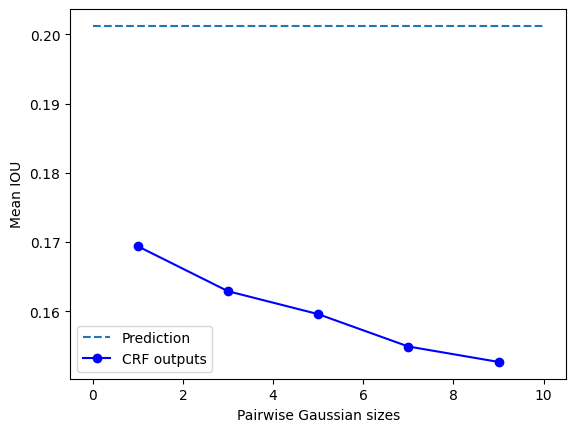

In [47]:
plt.plot([0, 10], [original_iou, original_iou], '--', label='Prediction')
plt.plot(gaussian_parameters, gaussian_mean_ious, 'bo-', label='CRF outputs')
# plt.plot(iterations_parameters, iterations_mean_ious, 'go-', label='CRF outputs from ground truth parameters')
plt.xlabel('Pairwise Gaussian sizes')
plt.legend(loc="lower left")
plt.ylabel('Mean IOU')
plt.show()

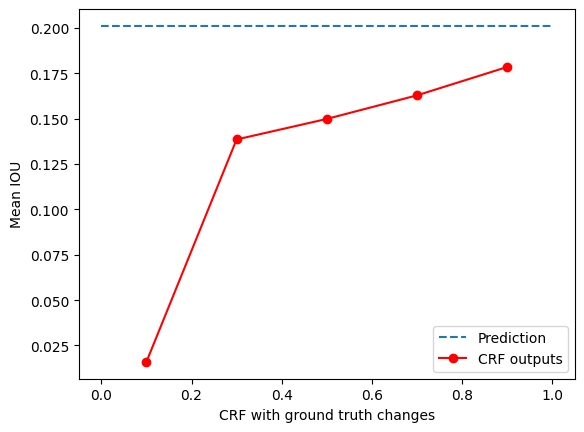

In [36]:
plt.plot([0, 1], [original_iou, original_iou], '--', label='Prediction')
plt.plot(gt_parameters, gt_mean_ious, 'ro-', label='CRF outputs')
# plt.plot(iterations_parameters, iterations_mean_ious, 'go-', label='CRF outputs from ground truth parameters')
plt.xlabel('CRF with ground truth changes')
plt.legend(loc="lower right")
plt.ylabel('Mean IOU')
plt.show()

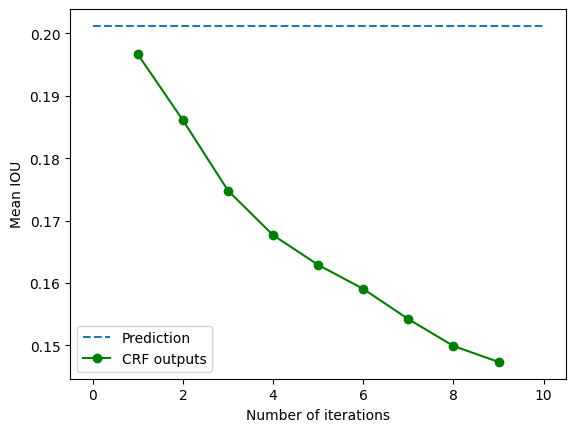

In [37]:
plt.plot([0, 10], [original_iou, original_iou], '--', label='Prediction')
# plt.plot(gt_parameters, gt_mean_ious, 'ro-', label='CRF outputs from ground truth parameters')
plt.plot(iterations_parameters, iterations_mean_ious, 'go-', label='CRF outputs')
plt.xlabel('Number of iterations')
plt.legend(loc="lower left")
plt.ylabel('Mean IOU')
plt.show()

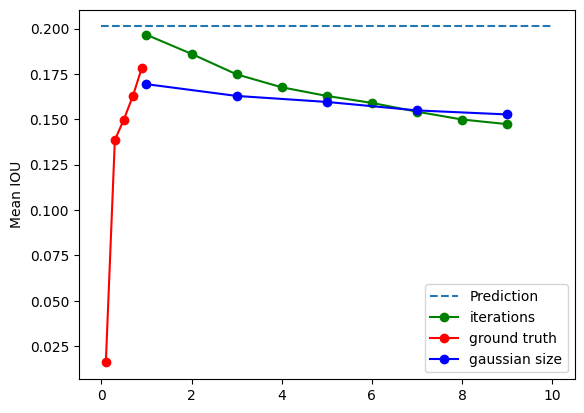

In [51]:
plt.plot([0, 10], [original_iou, original_iou], '--', label='Prediction')
# plt.plot(gt_parameters, gt_mean_ious, 'ro-', label='CRF outputs from ground truth parameters')
plt.plot(iterations_parameters, iterations_mean_ious, 'go-', label='iterations')
plt.plot(gt_parameters, gt_mean_ious, 'ro-', label='ground truth')
plt.plot(gaussian_parameters, gaussian_mean_ious, 'bo-', label='gaussian size')
plt.legend(loc="lower right")
plt.ylabel('Mean IOU')
plt.show()